# Import Libraries / Verify Setup

In [1]:
import warnings
warnings.filterwarnings('ignore') 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import xgboost as xgb
import shap

# Import Data

In [3]:
raw = pd.read_csv("../Data/diabetes2_raw.csv")
raw.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


# Data Cleaning

In [4]:
# Make a copy of the data
data = raw.copy(deep=True)

In [5]:
# Drop pre-diabetes patients
data = data[data["Diabetes_012"]!=1]
data["Diabetes"] = data["Diabetes_012"].apply(lambda x: 1 if x > 0 else 0)
data.drop(["Diabetes_012"],axis=1,inplace=True)
data = data.reset_index(drop=True)

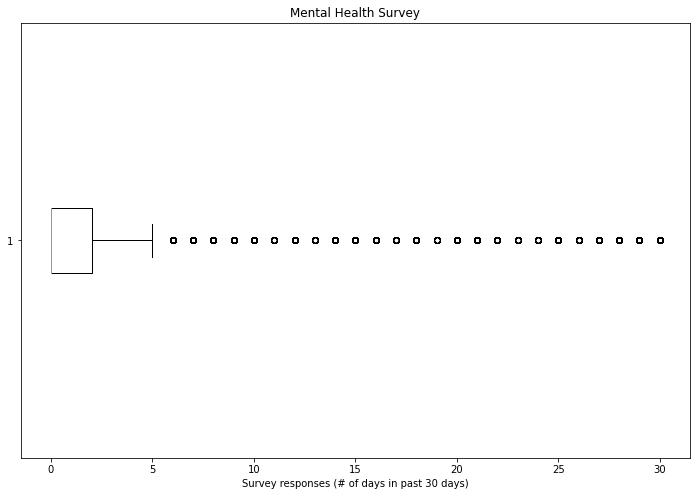

In [6]:
# Mental health feature engineering (binning approach)
plt.figure(figsize=(12,8))
plt.boxplot(data["MentHlth"],vert=False)
plt.xlabel("Survey responses (# of days in past 30 days)")
plt.title("Mental Health Survey")
plt.show()

mental_health = []
good = np.median(data["MentHlth"])
medium = np.quantile(data["MentHlth"],0.75) +\
         1.5*(np.quantile(data["MentHlth"],0.75)-np.quantile(data["MentHlth"],0.25))
for i in range(len(data)):
    if data["MentHlth"][i] <= good:
        mental_health.append(0)
    elif data["MentHlth"][i] <= medium:
        mental_health.append(1)
    else:
        mental_health.append(2)     
data["Mental_Health"] = mental_health
data.drop(["MentHlth"],axis=1,inplace=True)

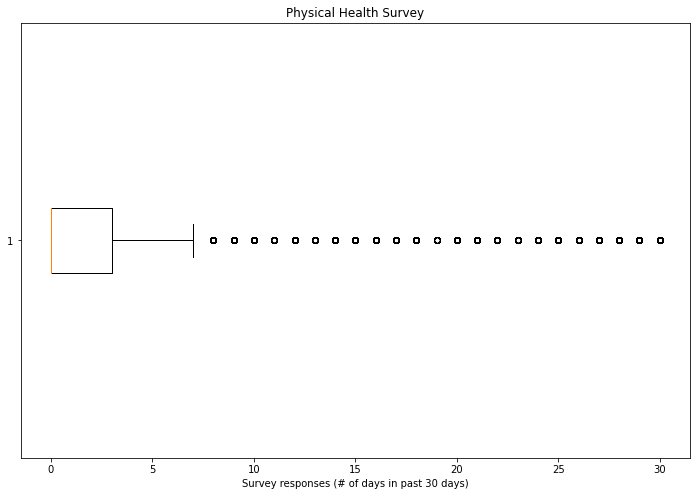

In [7]:
# Physical health feature engineering (binning approach)
plt.figure(figsize=(12,8))
plt.boxplot(data["PhysHlth"],vert=False)
plt.xlabel("Survey responses (# of days in past 30 days)")
plt.title("Physical Health Survey")
plt.show()

physical_health = []
good = np.median(data["PhysHlth"])
medium = np.quantile(data["PhysHlth"],0.75) +\
         1.5*(np.quantile(data["PhysHlth"],0.75)-np.quantile(data["PhysHlth"],0.25))
for i in range(len(data)):
    if data["PhysHlth"][i] <= good:
        physical_health.append(0)
    elif data["PhysHlth"][i] <= medium:
        physical_health.append(1)
    else:
        physical_health.append(2)
data["Physical_Health"] = physical_health
data.drop(["PhysHlth"],axis=1,inplace=True)

In [8]:
# General health feature cleaning (change to 1=bad, 5=good)
general_health = []
for i in range(len(data)):
    if data["GenHlth"][i] == 1:
        general_health.append(5)
    elif data["GenHlth"][i] == 2:
        general_health.append(4)
    elif data["GenHlth"][i] == 3:
        general_health.append(3)
    elif data["GenHlth"][i] == 4:
        general_health.append(2)
    else:
        general_health.append(1)
data["General_Health_Survey"] = general_health
data.drop(["GenHlth"],axis=1,inplace=True)

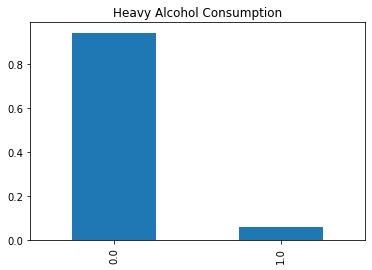

Heavy Alcohol Consumption -> Diabetes Correlation: -0.0579


In [9]:
# Remove heavy alcohol consumption feature (biased feature)
data["HvyAlcoholConsump"].value_counts(normalize=True).plot(kind="bar")
plt.title("Heavy Alcohol Consumption")
plt.show()

corr = data[["HvyAlcoholConsump","Diabetes"]].corr().values[0,1]
print(f"Heavy Alcohol Consumption -> Diabetes Correlation: {corr:.4f}")

data.drop(["HvyAlcoholConsump"],axis=1,inplace=True)

In [10]:
# Rename columns
data.columns = [
    "High_BP",
    "High_Chol",
    "Chol_Check",
    "BMI",
    "Smoker",
    "Stroke",
    "Heart_Disease_Attack",
    "Physical_Activity",
    "Fruits",
    "Veggies",
    "Healthcare",
    "No_Doctor_Cost",
    "Difficulty_Walk",
    "Sex",
    "Age",
    "Education",
    "Income",
    "Diabetes",
    "Mental_Health_Survey",
    "Physical_Health_Survey",
    "General_Health_Survey"
]

In [11]:
# Class imbalance
print(f"Number of rows: {data.shape[0]}")
print(f"Number of features: {data.shape[1]}")
print()
print(f"Class Imbalance: {data['Diabetes'].sum()/len(data):.4f}")
print(data["Diabetes"].value_counts())
print()
print(f"Baseline Accuracy: {(len(data)-data['Diabetes'].sum())/len(data):.4f}")

Number of rows: 249049
Number of features: 21

Class Imbalance: 0.1419
0    213703
1     35346
Name: Diabetes, dtype: int64

Baseline Accuracy: 0.8581


In [12]:
# Independent/dependent variables
X = data.drop(["Diabetes"],axis=1)
y = data["Diabetes"]

In [13]:
# Standardization
X_std = (X - np.mean(X,axis=0))/(np.std(X,axis=0))

# Load Models

In [14]:
with open("../Models/xgboost_custom","rb") as f:
    m_custom = pickle.load(f)

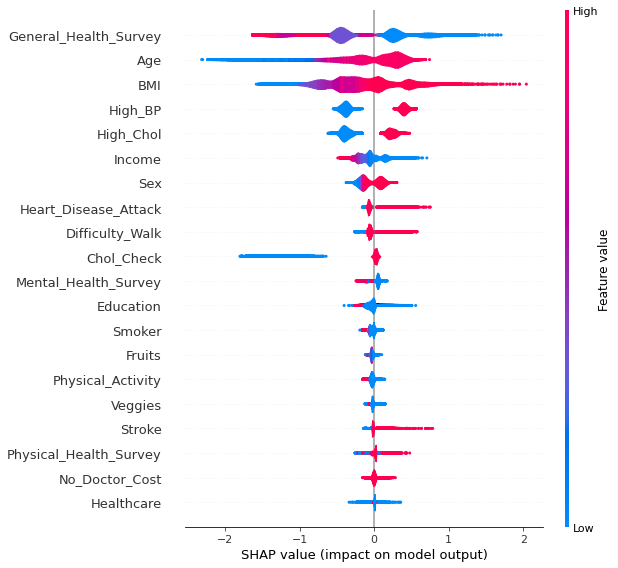

In [15]:
explainer = shap.TreeExplainer(m_custom)
shap_values = explainer.shap_values(X)
plt.figure(figsize=(20,12))
shap.summary_plot(shap_values,X,show=True,max_display=20,plot_type="violin")
plt.show()

In [16]:
m_custom.predict_proba(X)[:,1]

array([0.7271544 , 0.02681713, 0.49657866, ..., 0.01238948, 0.13294514,
       0.25514007], dtype=float32)

In [17]:
y

0         0
1         0
2         0
3         0
4         0
         ..
249044    0
249045    1
249046    0
249047    0
249048    1
Name: Diabetes, Length: 249049, dtype: int64